# Doppler Effect-Based Channel Charting

This Jupyter Notebook trains and evaluates the forward charting function (FCF) called $C_{\theta, \mathrm{Dop}}$ in the paper.
The FCF, implemented as a neural network, uses time-domain CIRs as NN inputs (features), and produces channel chart position estimates.
The loss function is based on the Doppler effect, i.e., phase changes over time / space as the transmitter moves.

Obviously, performance may vary slightly every time you train the neural network from scratch. So don't expect to the evaluation results here to perfectly match the results in the paper, but you will be able to achieve very similar performance.

In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import sklearn.manifold
import scipy.spatial
import numpy as np
import json

2024-04-14 17:03:08.658877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 17:03:09.338962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The dataset contains CSI from 4 antenna arrays with $2 \times 4$ antennas each.
However, in the paper, we claim that we can do channel charting with just 4 individual antennas.
So, while loading the dataset, we just retain the CSI data from one antenna per dataset.
The variables `SINGLE_ANTENNA_ROW` and `SINGLE_ANTENNA_COL` select which antenna to choose for each antenna array.

In [2]:
# Extract this *one single* antenna for each array
SINGLE_ANTENNA_ROW = 0
SINGLE_ANTENNA_COL = 2

In the following, note that we remove the time / phase synchronization from the time-domain CSI `csi_tdomain`, which is later used to as an input to the neural network (feature). The only reason to do this is to prove the point that we can do Doppler effect-based Channel Charting without requiring time / phase synchronization.

In [3]:
PATHS = [
    "dataset/dichasus-cf02.tfrecords",
    "dataset/dichasus-cf03.tfrecords",
    "dataset/dichasus-cf04.tfrecords"
]

SUBCARRIERS = 1024

spec = None

antenna_assignments = []
antenna_count = 0

with open("dataset/spec.json") as specfile:
    spec = json.load(specfile)
    for antenna in spec["antennas"]:
        antenna_count = antenna_count + sum([len(row) for row in antenna["assignments"]])
        antenna_assignments.append(antenna["assignments"])

def load_dataset_file(path):
    def record_parse_function(proto):
        record = tf.io.parse_single_example(
            proto,
            {
                "csi": tf.io.FixedLenFeature([], tf.string, default_value = ""),
                "cfo": tf.io.FixedLenFeature([], tf.string, default_value = ""),
                "pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value = ""),
                "time": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
            },
        )

        csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type=tf.float32), (antenna_count, SUBCARRIERS, 2))
        csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
        csi = tf.signal.fftshift(csi, axes=1)

        cfo = tf.ensure_shape(tf.io.parse_tensor(record["cfo"], out_type = tf.float32), (antenna_count))
        
        position = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64), (3))
        time = tf.ensure_shape(record["time"], ())

        return csi, position, time, cfo

    def csi_time_domain(csi, pos, time, cfo):
        # Note: STO is removed *per antenna* so that the features for the neural network are not synchronized either
        sto_increment_estimate = tf.cast(tf.math.angle(tf.math.reduce_sum(csi[...,1:] * tf.math.conj(csi[...,:-1]), axis = -1)), tf.complex64)
        csi_freq_domain_nosto = csi * tf.exp(-1.0j * sto_increment_estimate[:, tf.newaxis] * tf.cast(tf.range(csi.shape[-1]), tf.complex64)[tf.newaxis,:])
        csi_tdomain = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi_freq_domain_nosto, axes=1)), axes=1)

        # Randomize per-antenna, per-datapoint starting phase
        csi_tdomain = tf.exp(tf.complex(0.0, tf.random.uniform([csi_tdomain.shape[0]], -np.pi, np.pi)))[:, tf.newaxis] * csi_tdomain
        
        return csi, csi_tdomain, pos, time, cfo

    def cut_out_taps(tap_start, tap_stop):
        def cut_out_taps_func(csi, csi_tdomain, pos, time, cfo):
            return csi, csi_tdomain[:,tap_start:tap_stop], pos, time, cfo

        return cut_out_taps_func

    def order_by_antenna_assignments(csi, csi_tdomain, pos, time, cfo):
        csi = tf.stack([[tf.gather(csi, antenna_indices) for antenna_indices in array] for array in antenna_assignments])
        csi_tdomain = tf.stack([[tf.gather(csi_tdomain, antenna_indices) for antenna_indices in array] for array in antenna_assignments])
        cfo = tf.stack([[tf.gather(cfo, antenna_indices) for antenna_indices in array] for array in antenna_assignments])
        return csi, csi_tdomain, pos, time, cfo

    def extract_single_antenna(csi, csi_tdomain, pos, time, cfo):
        return csi[:,SINGLE_ANTENNA_ROW,SINGLE_ANTENNA_COL,:], csi_tdomain[:,SINGLE_ANTENNA_ROW,SINGLE_ANTENNA_COL,:], pos, time, cfo
    
    dset = tf.data.TFRecordDataset(path)
    dset = dset.map(record_parse_function, num_parallel_calls = tf.data.AUTOTUNE)
    dset = dset.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
    dset = dset.map(cut_out_taps(SUBCARRIERS // 2 - 5, SUBCARRIERS // 2 + 20), num_parallel_calls = tf.data.AUTOTUNE)
    dset = dset.map(order_by_antenna_assignments, num_parallel_calls = tf.data.AUTOTUNE)
    dset = dset.map(extract_single_antenna, num_parallel_calls = tf.data.AUTOTUNE)

    return dset

full_dataset = load_dataset_file(PATHS[0])

for path in PATHS[1:]:
    full_dataset = full_dataset.concatenate(load_dataset_file(path))

# The actual sampling right is slightly higher than 50 MHz due to fractional sampling rate issues
Fs = spec["bandwidth"]
Fc = spec["frequency"]
SCHEDULE_TIMEDIFF = spec["regular-schedule-interval"]

def training_set_filter(dataset):
    # Decimate training dataset: Use only every 4th datapoint (to reduce number of points)
    dataset = dataset.enumerate().filter(lambda idx, value : (idx % 4 == 0))
    return dataset.map(lambda idx, value : value)

def test_set_filter(dataset):
    # Decimate training dataset: Use only every 4th datapoint (to reduce number of points)
    dataset = dataset.enumerate().filter(lambda idx, value : ((idx + 2) % 4 == 0))
    return dataset.map(lambda idx, value : value)

training_set = full_dataset.apply(training_set_filter)
test_set = full_dataset.apply(test_set_filter)

2024-04-14 17:03:10.578817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 17:03:10.600730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 17:03:10.601026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Determine absolute (unwrapped) phase of all datapoints

We first want to determine what is called $\varphi_b^{(l)}$ in the paper, i.e., a function describing the overall phase measured at antenna $b$ for datapoint $l$.

The *dichasus-cf0x* dataset contains instantaneous antenna-specific measured frequency offset values in the `cfo` field of each datapoint. We could determine $\varphi_b^{(l)}$ by just integrating over the frequency offsets, but we can do even better than that by comparing the phase *expected* for the next datapoint based on the instantaneous frequency offset of the previous datapoint to the phase that we actually measure. Usually, the phase that we predict based on the phase of the previous datapoint and the CFO is going to be very close to the phase that we actually measure for the next datapoint (certaintly within $\pm \pi$), so in that case it is easy to update $\varphi_b^{(l)}$. This is the "big picture" description of what the next two code cells do.

We use *all* datapoints in the dataset to determine $\varphi_b^{(l)}$. Only later do we extract training set and test set.

Of course, the considered dataset has more than one subcarrier, so when we talk about the phase of the measured CSI, we just use the phase average over the lowermost 256 subcarriers here. There is certainly some room for improvement here. We use the lowermost 256 subcarriers (as opposed to just picking subcarriers from the middle of the bandwidth), because the phase synchronization there is most accurate. This has something to do with the FDD frequency synchronization signal being broadcast below the main transmitter signal. Feel free to contact me if you need more information on this point.

In [4]:
# Compute phase changes ("phase deltas") from one datapoint to the next,
# subtract phase changes which are to be expected based on mean CFO
def compute_time_phase_delta(prev, curr):
    prev_csi, prev_csi_tdomain, prev_pos, prev_time, prev_cfo = prev[0], prev[1], prev[2], prev[3], prev[4]
    curr_csi, curr_csi_tdomain, curr_pos, curr_time, curr_cfo = curr[0], curr[1], curr[2], curr[3], curr[4]

    dt = tf.math.round((curr_time - prev_time) / SCHEDULE_TIMEDIFF) * SCHEDULE_TIMEDIFF
    mean_cfo = tf.math.reduce_mean([prev_cfo, curr_cfo])

    # Expected changes in CPO/STO (purely based on mean CFO) from (i-1)-th datapoint to i-th datapoint
    predicted_cpo_change = tf.cast(-2 * np.pi * mean_cfo * dt, tf.complex64)
    predicted_sto_change = tf.cast(-mean_cfo / Fc * dt * Fs, tf.complex64)

    predicted_csi_change = tf.math.exp(1.0j * predicted_cpo_change) * tf.math.exp(1.0j * 2 * np.pi * predicted_sto_change * tf.cast(tf.range(-SUBCARRIERS // 2, SUBCARRIERS // 2), tf.complex64) / SUBCARRIERS)
    unexplained_csi_change = prev_csi / curr_csi * tf.math.conj(predicted_csi_change[tf.newaxis,:])

    return dt, tf.math.angle(tf.math.reduce_sum(unexplained_csi_change[:,:256], axis = 1))

phase_delta_dataset = tf.data.Dataset.zip(full_dataset, full_dataset.skip(1)).map(compute_time_phase_delta, num_parallel_calls = tf.data.AUTOTUNE)

phase_deltas = []
time_deltas = []

print("Computing differential phases...")
for dt, dphi in phase_delta_dataset.batch(500):
    time_deltas.append(dt)
    phase_deltas.append(dphi)
    if len(time_deltas) % 10 == 0:
        print("Batches loaded:", len(time_deltas))

phase_deltas = np.concatenate(phase_deltas)
time_deltas = np.concatenate(time_deltas)

Computing differential phases...
Batches loaded: 10
Batches loaded: 20
Batches loaded: 30
Batches loaded: 40
Batches loaded: 50
Batches loaded: 60
Batches loaded: 70
Batches loaded: 80
Batches loaded: 90
Batches loaded: 100
Batches loaded: 110
Batches loaded: 120
Batches loaded: 130
Batches loaded: 140
Batches loaded: 150
Batches loaded: 160


In [5]:
# MAX_VELOCITY only needs to be a *very* rough guess.
# The idea there basically is that we only want to update the phase to the measured value in the CSI tensor if we have any reasonable expectation of
# the solution being correct. Since some datapoints may be missing (we should sample in regular intervals, but sometimes we can't due to live re-synchronization
# of the channel sounder), there can be cases where we have large gaps between subsequent datapoints and we cannot expect a meaningful phase correction, in
# which case we just forego this procedure. But that case is really rare and almost irrelevant.
MAX_VELOCITY = 1
WAVELENGTH = 3e8 / Fc
MAX_TIMEDIFF = 10

# Integrate over phase changes to get absolute cumulative phases, and fix ambiguities in phases when
# a scheduled measurement datapoint is skipped.
cumulative_phases_all = np.zeros((phase_deltas.shape[0] + 1, phase_deltas.shape[1]))

for array in range(phase_deltas.shape[1]):
    cumphase_ambiguous = np.cumsum(phase_deltas[:,array])

    cumphase = np.zeros_like(cumphase_ambiguous)
    discont_phase_shift = 0
    for t in tqdm(range(len(cumphase_ambiguous)), desc = f"Computing cumulative phases for antenna {array}"):
        if time_deltas[t] * MAX_VELOCITY > WAVELENGTH / 2 and time_deltas[t] < MAX_TIMEDIFF:
            # It is possible that the transmitter travelled by more than half a wavelength
            # between this datapoint and the previous one, so there is some ambiguity by 
            # multiples of one wavelength. Extrapolate from previous two datapoints and
            # pick most likely solution.
            extrapolated_phase = cumphase_ambiguous[t - 1] + (cumphase_ambiguous[t - 1] - cumphase_ambiguous[t - 2]) / time_deltas[t - 1] * time_deltas[t]
            measured_phase = cumphase_ambiguous[t]
            likely_phase = extrapolated_phase + (measured_phase - extrapolated_phase + np.pi) % (2 * np.pi) - np.pi
            discont_phase_shift = discont_phase_shift + likely_phase - measured_phase

        cumulative_phases_all[1 + t, array] = cumphase_ambiguous[t] + discont_phase_shift

def fuse_cumulative_phase(datapoint, cumphase):
    return *datapoint, cumphase

training_set_with_phases = tf.data.Dataset.zip(full_dataset, tf.data.Dataset.from_tensor_slices(cumulative_phases_all)).map(fuse_cumulative_phase).apply(training_set_filter)

Computing cumulative phases for antenna 0:   0%|          | 0/83402 [00:00<?, ?it/s]

Computing cumulative phases for antenna 1:   0%|          | 0/83402 [00:00<?, ?it/s]

Computing cumulative phases for antenna 2:   0%|          | 0/83402 [00:00<?, ?it/s]

Computing cumulative phases for antenna 3:   0%|          | 0/83402 [00:00<?, ?it/s]

2024-04-14 17:03:47.161223: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [6]:
def csi_to_delayspreads_by_antenna(csi, csi_tdomain, pos, time, cfo, cumphase):
    powers = tf.square(tf.abs(csi_tdomain))
    timestamps = tf.range(tf.shape(csi_tdomain)[-1], dtype = tf.float32) / spec["bandwidth"]
    time_weighted_powers = tf.einsum("...t,t->...t", powers, timestamps)
    mean_delays = tf.divide(tf.reduce_sum(time_weighted_powers, axis = -1), tf.reduce_sum(powers, axis = -1))
    squared_delays = tf.square(timestamps[tf.newaxis, :] - mean_delays[:, tf.newaxis])
    delayspreads = tf.sqrt(tf.divide(tf.reduce_sum(tf.multiply(squared_delays, powers), axis = -1), tf.reduce_sum(powers, axis = -1)))

    return csi, csi_tdomain, pos, time, cfo, cumphase, delayspreads

In [7]:
groundtruth_positions = []
cumulative_phases = []
csi_time_domain = []
delayspreads = []
timestamps = []

for csi, csi_tdomain, pos, time, cfo, cumphase, ds in training_set_with_phases.map(csi_to_delayspreads_by_antenna).batch(1000):
    groundtruth_positions.append(pos.numpy())
    cumulative_phases.append(cumphase.numpy())
    csi_time_domain.append(csi_tdomain.numpy())
    delayspreads.append(ds.numpy())
    timestamps.append(time.numpy())

groundtruth_positions = np.concatenate(groundtruth_positions)
cumulative_phases = np.concatenate(cumulative_phases)
csi_time_domain = np.concatenate(csi_time_domain)
delayspreads = np.concatenate(delayspreads)
timestamps = np.concatenate(timestamps)

When looking at $\varphi_b^{(l)}$", we see that the curve does not look arbitrary at all!
Waht we see here is the movement of the transmitter, which causes a phase shift (can be viewed as Doppler effect, or can be viewed as position-dependent delay, both descriptions are equivalent).
By the way, the long "flat" parts of the curve are actually the gaps (timestamp-wise) between the different files in the dataset.

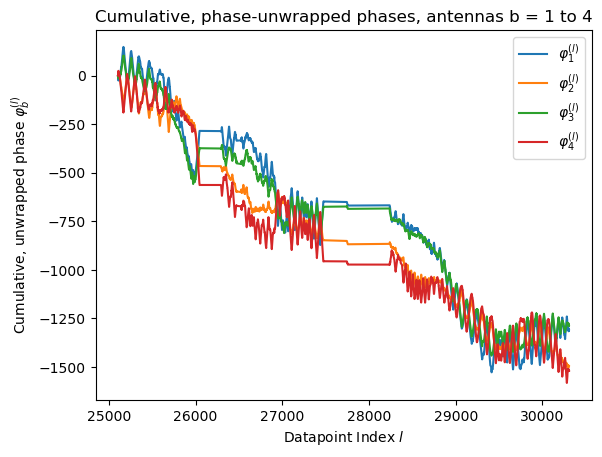

In [8]:
plt.plot(timestamps, cumulative_phases, label = ["$\\varphi_1^{(l)}$", "$\\varphi_2^{(l)}$", "$\\varphi_3^{(l)}$", "$\\varphi_4^{(l)}$"])
plt.xlabel("Datapoint Index $l$")
plt.ylabel("Cumulative, unwrapped phase $\\varphi_b^{(l)}$")
plt.title("Cumulative, phase-unwrapped phases, antennas b = 1 to 4")
plt.legend()
plt.show()

### Phase uncertainty heuristic

In the paper, we call this heuristic $u_b^{(l)}$.
Admittedly, the way we compute the uncertainty that we have about $\varphi_b^{(l)}$ is quite arbitrary, we just use the delay spread, plug it into some function, and get a value out that we integrate over (`cumsum`).
There is certainly room for improvement here, but it works well enough.

Again, the large jumps that you see in the curve of $U_b^{(l)}$ is due to the gaps between the dataset files.
They are totally expected and a good thing.
Basically, these gaps indicate that after not having observed any phase measurement from the transmitter for a sufficiently long time, we have no idea to tell anymore how accurate a phase measurement is that we may receive at a later point in time.

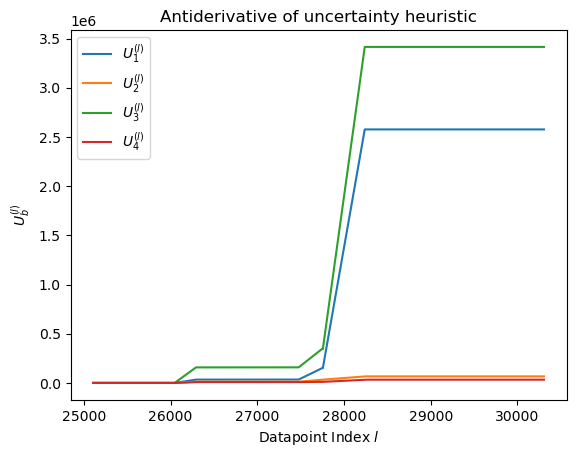

In [9]:
dt = np.concatenate([[0], timestamps[1:] - timestamps[:-1]])
phase_uncertainties = np.cumsum((delayspreads * dt[:, np.newaxis] * 1e6)**4, axis = 0)
plt.plot(timestamps, phase_uncertainties, label = ["$U_1^{(l)}$", "$U_2^{(l)}$", "$U_3^{(l)}$", "$U_4^{(l)}$"])
plt.xlabel("Datapoint Index $l$")
plt.ylabel("$U_b^{(l)}$")
plt.title("Antiderivative of uncertainty heuristic")
plt.legend()
plt.show()

In [10]:
# We assume that z-coordinate of TX is constant and known
HEIGHT = np.mean(groundtruth_positions[:,2])

In [11]:
def plot_colorized(positions, reference_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(reference_positions[:, 0], axis = 0) + np.max(reference_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(reference_positions[:, 1], axis = 0) + np.max(reference_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((reference_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(reference_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(reference_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(reference_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

def plot_quiver(positions, reference_positions, title = None, nth_errorvector = 15):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    mae = np.mean(errors)
    
    fulltitle = f"Error Vectors, MAE = {mae:.4f}m"
    if title is not None:
        fulltitle = title + " - " + fulltitle
    plot_colorized(positions, reference_positions, title = fulltitle, show = False, alpha = 0.3)
    plt.quiver(positions[::nth_errorvector, 0], positions[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
    plt.show()

This is the FCF neural network's input layer that extracts logarithmic power delay profile, as well as real and imaginary parts of the CIR.
The FCF will learn to map these CIR "fingerprints", which are hopefully unique in the considered multipath environment, to the location in the channel chart.
Note that `csi_tdomain` is not time / phase synchronized, we got rid of that synchronization in the previous dataset loading step.

In [12]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi_tdomain):
        pdp = tf.math.abs(csi_tdomain)
        pdp_logarithmic = tf.math.log(pdp) / tf.math.log(10.0)
        return tf.stack([pdp_logarithmic, tf.math.real(csi_tdomain), tf.math.imag(csi_tdomain)], axis = -1)

If a GPU is available, copy everything to GPU memory for faster training.

In [13]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
cumulative_phases_tensor = tf.constant(cumulative_phases, dtype = tf.float32)
phase_uncertainties_tensor = tf.constant(phase_uncertainties, dtype = tf.float32)

In [14]:
datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    indexA = randA % datapoint_count
    indexB = randB % datapoint_count
    input = (csi_time_domain_tensor[indexA], csi_time_domain_tensor[indexB])
    labels = tf.concat(
        [
            cumulative_phases_tensor[indexA],
            cumulative_phases_tensor[indexB],
            phase_uncertainties_tensor[indexA],
            phase_uncertainties_tensor[indexB]
        ], 0)
    return input, labels

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

### FCF Neural Network Definition

In [15]:
array_count = np.shape(csi_time_domain)[1]
tap_count = np.shape(csi_time_domain)[2]

cc_embmodel_input = tf.keras.Input(shape = (array_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs = cc_embmodel_input, outputs = cc_embmodel_output, name = "ForwardChartingFunction")

In [16]:
array_positions = np.zeros((len(spec["antennas"]), 3))

for antidx, antenna in enumerate(spec["antennas"]):
    array_positions[antidx] = np.asarray(antenna["location"])

shift = np.mean(array_positions, axis = 0)[:2]
array_positions = array_positions
array_positions_tensor = tf.constant(array_positions, dtype = tf.float32)

### Loss Function
The following function implements the log-likelihood function $\mathcal L$.
Actually, we implement the function in a vectorized manner such that it can operated on whole batches of position estimates, phase measurements and uncertainties.
We want to maximize the log-likelihood, so we want to minimize the negated version of $\mathcal L$ and use that as a loss function for Siamese NN training.

In [17]:
def doppler_phase_loss_vectorized(pos_A, pos_B, phases_A, phases_B, uncertainties_A, uncertainties_B, sigma_beta, shift):
    pos_A_with_height = tf.concat([pos_A + shift[tf.newaxis, :], HEIGHT * tf.ones(tf.shape(pos_A)[0])[:, tf.newaxis]], 1)
    pos_B_with_height = tf.concat([pos_B + shift[tf.newaxis, :], HEIGHT * tf.ones(tf.shape(pos_B)[0])[:, tf.newaxis]], 1)

    # Positions A / B relative to the antenna arrays
    # shape: (datapoints, array, 3D)
    relative_pos_A = pos_A_with_height[:,tf.newaxis,:] - array_positions_tensor
    relative_pos_B = pos_B_with_height[:,tf.newaxis,:] - array_positions_tensor

    # Distances to the antenna arrays for all positions
    # shape: (datapoints, array)
    distance_to_arrays_A = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(relative_pos_A), axis = -1))
    distance_to_arrays_B = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(relative_pos_B), axis = -1))

    # Matrix of difference in distances: ((distance to arrayX) - (distance to arrayY))
    # shape: (datapoints, arrayX, arrayY)
    distances_to_arrays_diff_A = distance_to_arrays_A[:,tf.newaxis,:] - distance_to_arrays_A[:,:,tf.newaxis]
    distances_to_arrays_diff_B = distance_to_arrays_B[:,tf.newaxis,:] - distance_to_arrays_B[:,:,tf.newaxis]

    # Differences in distance matrices between points A and B (yes, difference of difference of distance, it gets confusing...)
    # shape: (datapoints, arrayX, arrayY)
    distances_to_arrays_diff_diff = distances_to_arrays_diff_A - distances_to_arrays_diff_B

    # Difference in received phases between arrayX and arrayY
    # shape: (datapoints, arrayX, arrayY)
    phases_diff_A = phases_A[:,tf.newaxis,:] - phases_A[:,:,tf.newaxis]
    phases_diff_B = phases_B[:,tf.newaxis,:] - phases_B[:,:,tf.newaxis]

    # Difference in phase difference between arrayX and arrayY between datapoints A and B
    # shape: (datapoints, arrayX, arrayY)
    phases_diff_diff = phases_diff_A - phases_diff_B

    # Uncertainties (assumed standard deviation of phase estimate)
    # shape: (datapoints, arrayX, arrayY)
    uncertainties_diff = tf.math.abs(uncertainties_A - uncertainties_B)
    sigma = tf.abs(uncertainties_diff[:, tf.newaxis, :]) + tf.abs(uncertainties_diff[:, :, tf.newaxis]) + sigma_beta
    
    # Now we can compare the phase differences
    phases_diff_diff_meters = phases_diff_diff / (2 * np.pi) * WAVELENGTH
    
    return tf.math.reduce_sum(tf.square((distances_to_arrays_diff_diff - phases_diff_diff_meters) / (sigma)))

In [18]:
def get_loss(sigma_beta, shift):
    def loss(y_true, y_pred):
        pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    
        phases_A = y_true[:,0:4]
        phases_B = y_true[:,4:8]
        uncertainties_A = y_true[:,8:12]
        uncertainties_B = y_true[:,12:16]
    
        return doppler_phase_loss_vectorized(pos_A, pos_B, phases_A, phases_B, uncertainties_A, uncertainties_B, sigma_beta, shift)

    return loss

### Siamese Neural Network

Arrange two FCF neural networks into a Siamese neural network configuration for training.

In [19]:
input_A = tf.keras.layers.Input(shape = (array_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

### Training Loop


Training Session  1 
Batch Size:  600 
Learning rate:  0.005


2024-04-14 17:04:09.508331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-14 17:04:09.542911: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f27161f2710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-14 17:04:09.542947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-14 17:04:09.547252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 17:04:09.559087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-14 17:04:09.649660: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

652/652 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 3.8186m


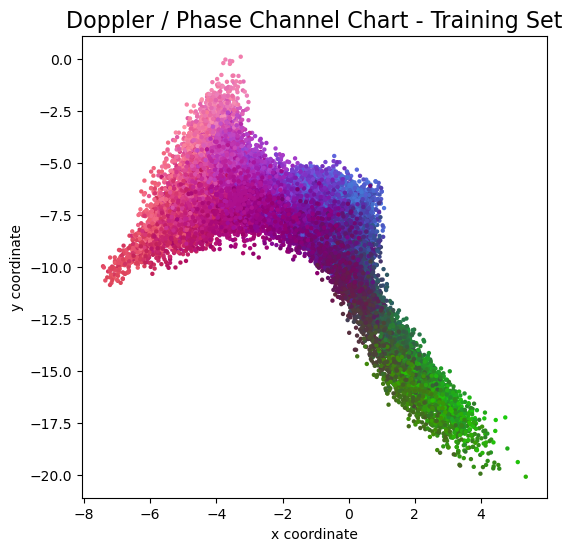

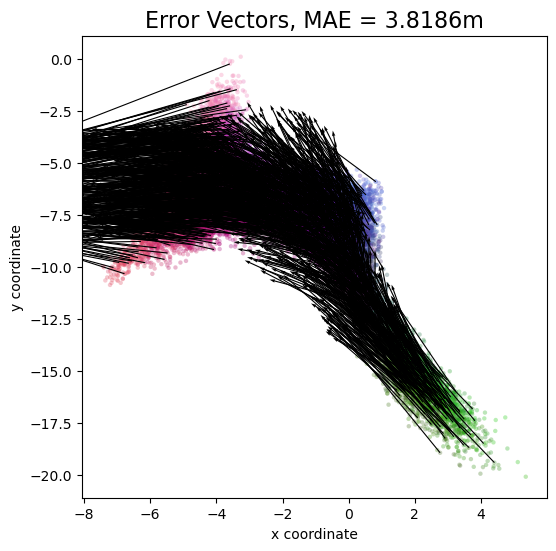


Training Session  2 
Batch Size:  800 
Learning rate:  0.002
652/652 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 3.0652m


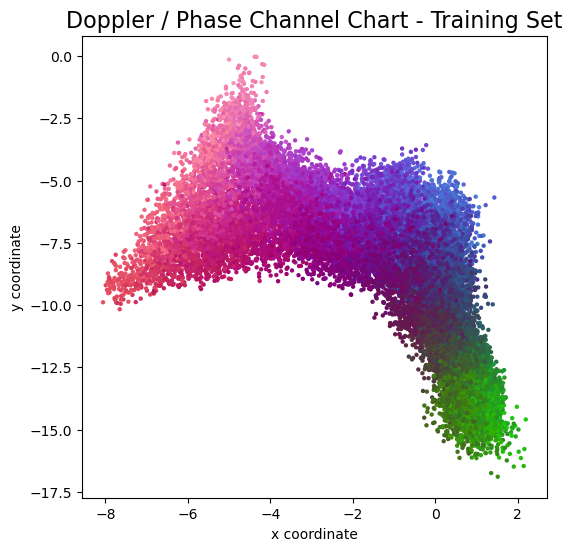

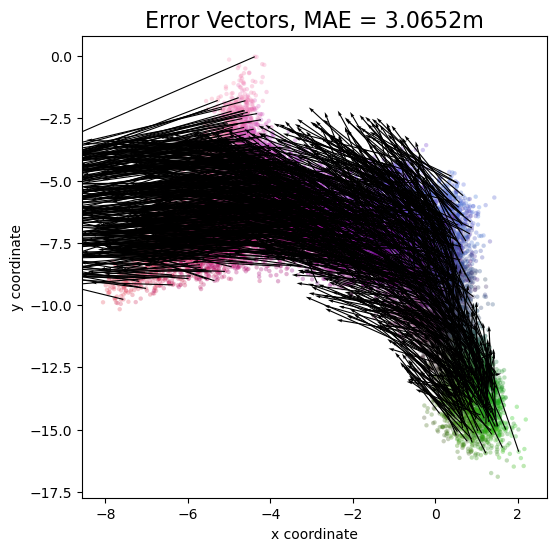


Training Session  3 
Batch Size:  1200 
Learning rate:  0.001
652/652 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 2.0026m


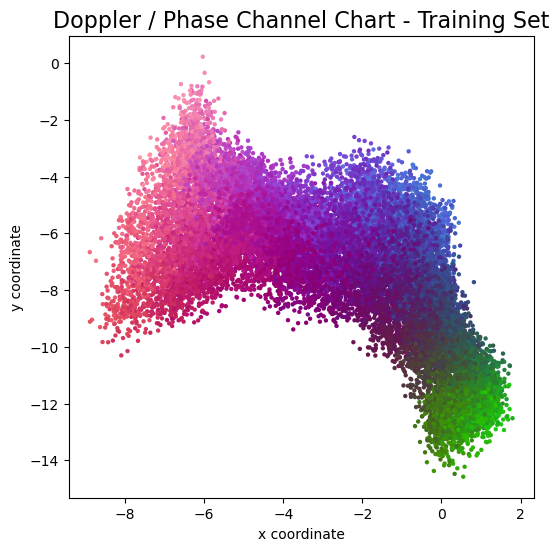

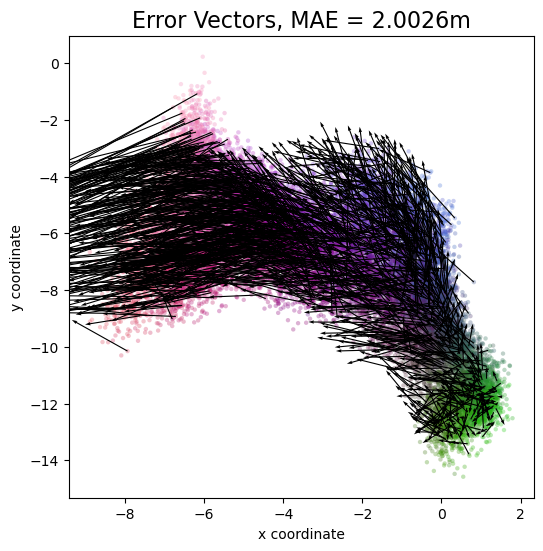


Training Session  4 
Batch Size:  2000 
Learning rate:  0.001
652/652 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 1.2762m


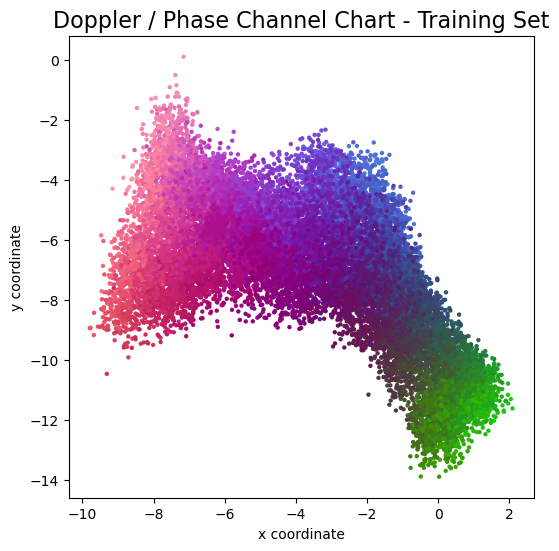

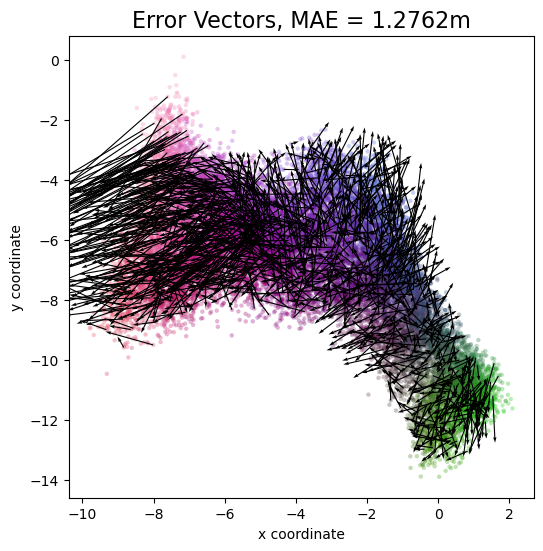


Training Session  5 
Batch Size:  2000 
Learning rate:  0.0001
652/652 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 1.2757m


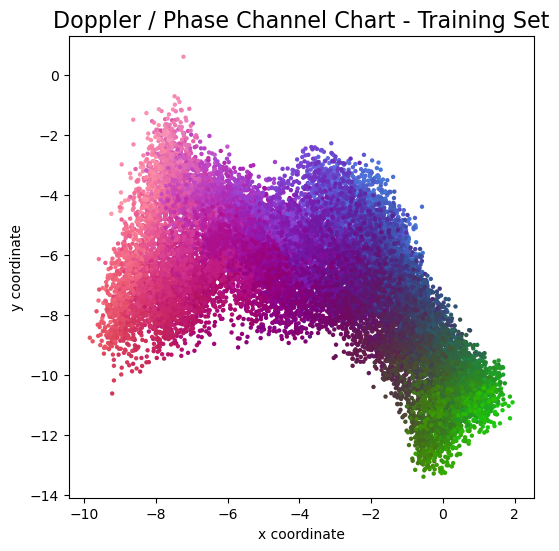

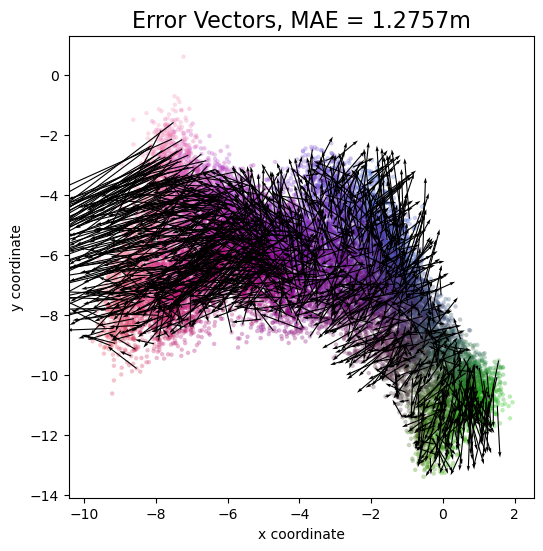


Training Session  6 
Batch Size:  2000 
Learning rate:  0.0001
652/652 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 1.2508m


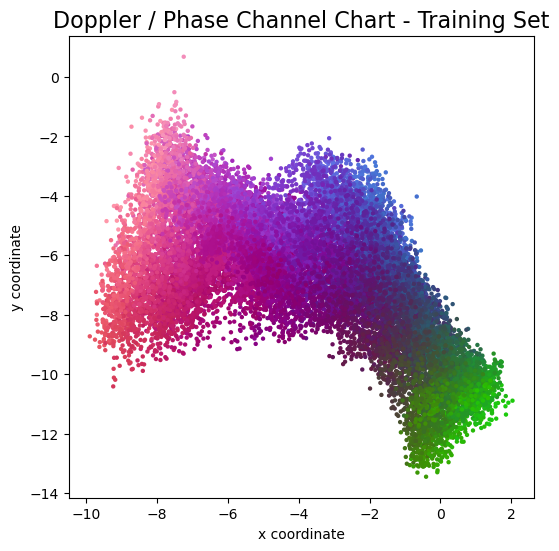

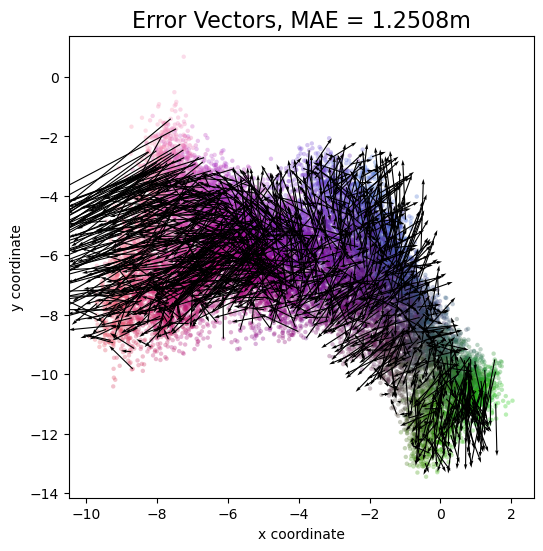

In [20]:
optimizer = tf.keras.optimizers.Adam()

# Feel free to tweak these training hyperparameters - a good choice of these paremters is important for performance!
samples_per_session = 300000
learning_rates = [5e-3, 2e-3, 1e-3, 1e-3, 1e-4, 1e-4]
batch_sizes = [600, 800, 1200, 2000, 2000, 2000]
sigma_betas = [0.4, 0.3, 0.2, 0.1, 0.1, 0.1]

for session, learning_rate, batch_size, sigma_beta in zip(range(len(learning_rates)), learning_rates, batch_sizes, sigma_betas):
    print("\nTraining Session ", session + 1, "\nBatch Size: ", batch_size, "\nLearning rate: ", learning_rate)

    # Fit model
    model.compile(loss = get_loss(sigma_beta, tf.constant(shift, dtype = tf.float32)), optimizer = optimizer)
    optimizer.learning_rate.assign(learning_rate)
    steps_per_epoch = int(samples_per_session / batch_size)
    model.fit(random_pair_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE), steps_per_epoch = steps_per_epoch)

    # Quick evaluation
    channel_chart_positions = cc_embmodel.predict(csi_time_domain_tensor) + shift[np.newaxis,:]
    errorvectors = groundtruth_positions[:,:2] - channel_chart_positions

    print(f"Mean Absolute Error (MAE): {np.mean(np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)):.4f}m")

    plot_colorized(channel_chart_positions, groundtruth_positions, title = "Doppler / Phase Channel Chart - Training Set")
    plot_quiver(channel_chart_positions, groundtruth_positions)

# Evaluation

Note that we evaluate on the training set here (which is reasonable, since we are evaluating a self-supervised learning technique). But it is just as easy to evaluate on the test set, and you will get very similar results (see paper).

### Helper Functions

In [21]:
# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return sklearn.manifold.trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded):
    dist_X = scipy.spatial.distance_matrix(X, X)
    dist_X_embedded = scipy.spatial.distance_matrix(X_embedded, X_embedded)
    beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

    return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

def plot_ecdf(err, label = None):
    count, bins_count = np.histogram(err, bins=200)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    bins_count[0] = 0
    cdf = np.append([0], cdf)

    plt.plot(bins_count, cdf, label = label)

### Directly Evaluate learned FCF, Without Optimal Affine Transform

Ideally, since we provided the position of the BS antennas to the loss function, the neural network should have been able to learn an FCF which produces a channel chart that is meaningful in the global coordinate frame.

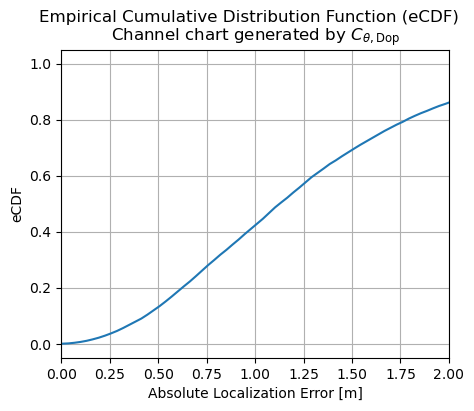

In [22]:
errorvectors = groundtruth_positions[:,:2] - channel_chart_positions
errors = np.sqrt(np.sum(np.square(errorvectors), axis = 1))

plt.figure(figsize=(5, 4))
plot_ecdf(errors)
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("eCDF")
plt.suptitle("Empirical Cumulative Distribution Function (eCDF)")
plt.title("Channel chart generated by $C_{\\theta, \\mathrm{Dop}}$")
plt.grid()
plt.show()

In [23]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = np.random.choice(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = sklearn.manifold.trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

print(f" MAE: {np.mean(errors):.3f}m")
print(f"DRMS: {np.sqrt(np.mean(np.square(errors))):.3f}m")
print(f" CEP: {np.median(errors):.3f}m")
print(f" R95: {np.percentile(errors, 95):.3f}m")
print(f"  CT: {ct:.4f}")
print(f"  TW: {tw:.4f}")
print(f"  KS: {ks:.4f}")

 MAE: 1.251m
DRMS: 1.455m
 CEP: 1.127m
 R95: 2.638m
  CT: 0.9543
  TW: 0.9526
  KS: 0.1690


### Evaluation After Optimal Affine Transform

First, find the optimally transformed channel chart.

652/652 [==============================] - 1s 2ms/step


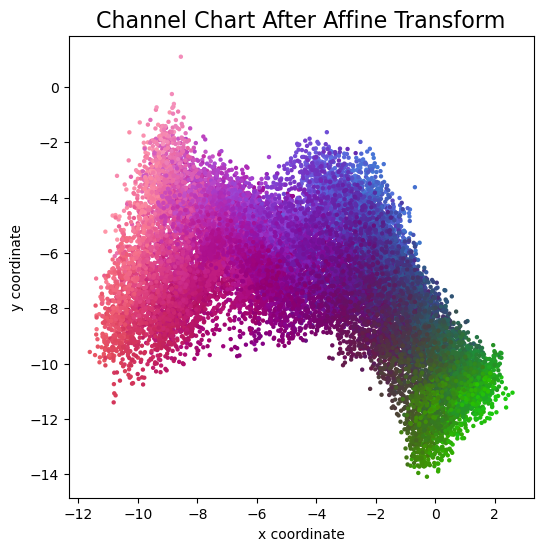

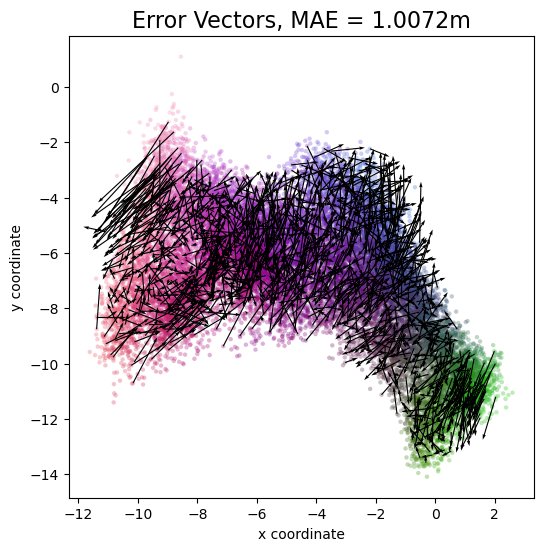

In [24]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain) + shift

def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Channel Chart After Affine Transform")
plot_quiver(channel_chart_positions_transformed[:,:2], groundtruth_positions[:,:2])

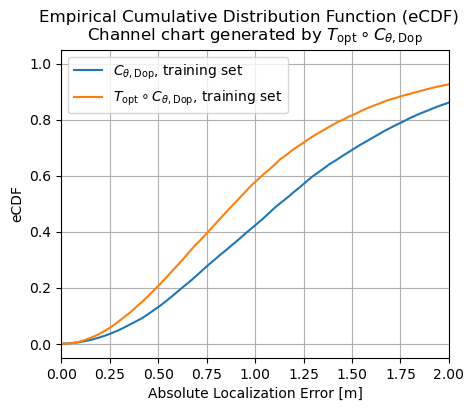

In [25]:
errorvectors_transformed = groundtruth_positions[:,:2] - channel_chart_positions_transformed[:,:2]
errors_transformed = np.sqrt(errorvectors_transformed[:,0]**2 + errorvectors_transformed[:,1]**2)

plt.figure(figsize=(5, 4))
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("eCDF")
plt.suptitle("Empirical Cumulative Distribution Function (eCDF)")
plt.title("Channel chart generated by $T_\mathrm{opt} \\circ C_{\\theta, \\mathrm{Dop}}$")
plt.grid()
plot_ecdf(errors, label = "$C_{\\theta, \\mathrm{Dop}}$, training set")
plot_ecdf(errors_transformed, label = "$T_\\mathrm{opt} \\circ C_{\\theta, \\mathrm{Dop}}$, training set")
plt.legend()
plt.show()

In [26]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = np.random.choice(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_transformed_subset = channel_chart_positions_transformed[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_transformed_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = sklearn.manifold.trustworthiness(groundtruth_positions_subset, channel_chart_positions_transformed_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_transformed_subset)

print(f" MAE: {np.mean(errors_transformed):.3f}m")
print(f"DRMS: {np.sqrt(np.mean(np.square(errors_transformed))):.3f}m")
print(f" CEP: {np.median(errors_transformed):.3f}m")
print(f" R95: {np.percentile(errors_transformed, 95):.3f}m")
print(f"  CT: {ct:.4f}")
print(f"  TW: {tw:.4f}")
print(f"  KS: {ks:.4f}")

 MAE: 1.007m
DRMS: 1.182m
 CEP: 0.891m
 R95: 2.203m
  CT: 0.9570
  TW: 0.9547
  KS: 0.1631


### Evaluation on Test Set, without optimal affine transform

In [27]:
groundtruth_positions_testset = []

for csi, csi_tdomain, pos, time, cfo in test_set.prefetch(tf.data.AUTOTUNE).batch(1000):
    groundtruth_positions_testset.append(pos.numpy())

groundtruth_positions_testset = np.concatenate(groundtruth_positions_testset)

In [28]:
channel_chart_positions_testset = cc_embmodel.predict(test_set.map(lambda csi, csi_tdomain, pos, time, cfo : csi_tdomain).prefetch(tf.data.AUTOTUNE).batch(1000)) + shift

21/21 [==============================] - 19s 916ms/step


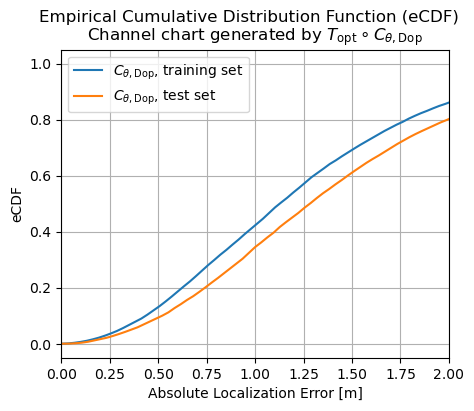

In [29]:
errorvectors_testset = groundtruth_positions[:,:2] - channel_chart_positions_testset[:,:2]
errors_testset = np.sqrt(errorvectors_testset[:,0]**2 + errorvectors_testset[:,1]**2)

plt.figure(figsize=(5, 4))
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("eCDF")
plt.suptitle("Empirical Cumulative Distribution Function (eCDF)")
plt.title("Channel chart generated by $T_\mathrm{opt} \\circ C_{\\theta, \\mathrm{Dop}}$")
plt.grid()
plot_ecdf(errors, label = "$C_{\\theta, \\mathrm{Dop}}$, training set")
plot_ecdf(errors_testset, label = "$C_{\\theta, \\mathrm{Dop}}$, test set")
plt.legend()
plt.show()

In [30]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = np.random.choice(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_testset_subset = channel_chart_positions_transformed[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_testset_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = sklearn.manifold.trustworthiness(groundtruth_positions_subset, channel_chart_positions_testset_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_testset_subset)

print(f" MAE: {np.mean(errors_testset):.3f}m")
print(f"DRMS: {np.sqrt(np.mean(np.square(errors_testset))):.3f}m")
print(f" CEP: {np.median(errors_testset):.3f}m")
print(f" R95: {np.percentile(errors_testset, 95):.3f}m")
print(f"  CT: {ct:.4f}")
print(f"  TW: {tw:.4f}")
print(f"  KS: {ks:.4f}")

 MAE: 1.411m
DRMS: 1.620m
 CEP: 1.281m
 R95: 2.919m
  CT: 0.9581
  TW: 0.9567
  KS: 0.1601
